# Tarea 2: Estimadores OLS - MLE - Momentos 

#### MDS7101 Estadística: Teoría y Aplicaciones
**Profesora:** Constanza Contreras  
**Auxiliar:** Carolina Salgado  
**Ayudante:** Camila Pulgar  
  
**Estudiantes:** Canela Orellana y Maximiliano Varas


En la presente tarea intentaremos dar respuesta a alguna pregunta de investigación que
debe escoger. 


Utilizaremos las herramientas vistas durante las cátedras para comprender el
fenómeno/experimento en observación.


Para realizar el análisis, por supuesto que necesitaremos datos. Idealmente utilice el mismo
problema y datos de la Tarea 1. De no calzar con los objetivos de esta tarea, puede buscar
en repositorios abiertos como el de Kaggle.com algún dataset que le sirva para realizar sus
análisis o utilizar datos que posea si es un tema en el cual ha trabajado antes.

In [70]:
# Paquetes para tratamiento de datos
import pandas as pd
import numpy as np
from itertools import product

# Librerías gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Paquetes estadísticos
import scipy.stats as ss
from scipy.stats import norm, lognorm, kstest, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

# Librerías para machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Parte 1: Estimación

### 1. Se realiza un breve recordatorio de lo desarrollado en la primera tarea. 
**Se menciona la pregunta de investigación planteada, el contexto en el cual se enmarca, los datos utilizados y las principales conclusiones que se obtuvieron.**

Se mantendrá la pregunta y datos utilizados en la primera tarea. La pregunta de investigación correspondía a: ¿Qué afecta el precio de las viviendas en Chile? Dado que en los últimos años se ha visto un alza constante de precios a lo largo de todo el país. Si bien el alza de precio representa un fenómeno mundial, relacionado con varios factores, como la inflación, sucede que los sueldos de los ciudadanos no aumentan al mismo ritmo, provocando que cada vez sea más difícil acceder a una vivienda propia. Dado que este representa un problema para la población, nos parece de interés comenzar a estudiar el fenómeno y en base a ello se definió la pregunta.  

Utilizamos un datase llamado **Valor Casas Usadas, Chile, RM, 08/03/2023** disponible en [Kaggle](https://www.kaggle.com/datasets/luisfelipetn/valor-casas-usadas-chile-rm-08032023), el cual se obtuvo realizando Web Scraping a la página https://chilepropiedades.cl/. Es importante mencionar que por ese motivo el dataser sólo contiene casas en venta, es decir, no se incluyen departamentos o terrenos. Nos parece que este dataset representa una buena muestra para aproximarse a la pregunta de investigación planteada.  

En la realización de la primera tarea se plantearon test de hipótesis que arrojaron la siguiente información:

- Existe evidencia estadísticamente significativa al  1% para rechazar la hipótesis nula de que la proporción de casas de mayor valor es igual a la proporción de casas de menor valor en el sector Nororiente. Con lo cual, los datos afirman que la proporción de casas de mayor valor es más alta en el sector Nororiente de la Región Metropolitana con respecto a las casas de menor valor.

- Existe evidencia estadísticamente significativa al  5% para rechazar la hipótesis nula de que las distribuciones son iguales. Es decir, los datos afirman que la distribución de área total de las casas de mayor valor es diferente a la distribución de área total de las casas de menor valor. Esto se contrasta con la información obtenida con los gráficos de la primera parte, donde no se había logrado concluir ninguna relación clara.

- Dado que el p-valor es menor al nivel de significancia definido al  1%, se puede afirmar que existe evidencia estadísticamente significativa para rechazar la hipótesis nula. Es decir, los datos afirman que las casas de mayor valor tienen en promedio mayor cantidad de dormitorios que las casas de menor valor.



### 2. Se plantea un modelo paramétrico para el caso de estudio y la forma de estimarlo.
**Se justifican ambas elecciones.**

Cargamos los datos para graficar la variable de estudio y así plantear el modelo paramétrico para este caso en particular

In [71]:
#Se cargan los datos limpios (Tarea 1)
data = pd.read_csv("data_clear.csv")
data.head()

,Dorms,Baths,Built Area,Total Area,Parking,Sector,Price_CLP_MM
0,2,1.0,112.0,145.0,1.0,Sur,105.00
1,3,1.0,59.0,243.0,2.0,Surponiente,128.12
2,3,1.0,103.0,73.0,1.0,Norte,75.00
3,2,1.0,57.0,67.0,1.0,Norte,53.00
4,3,1.0,70.0,80.0,2.0,Norte,75.00


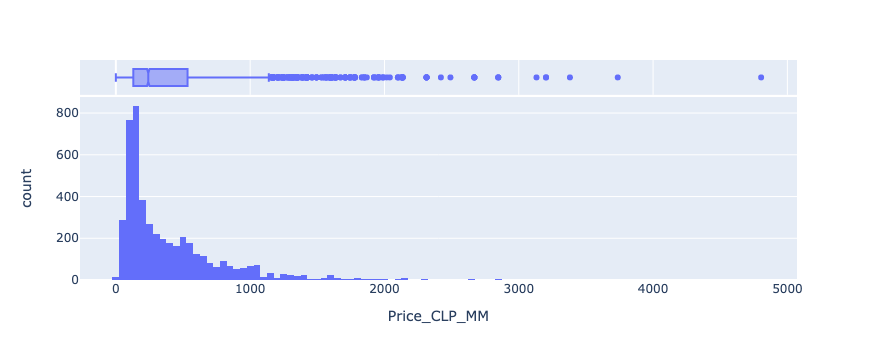

In [72]:
fig = px.histogram(data, x="Price_CLP_MM",marginal='box')
fig.show()

In [73]:
data.describe()

,Dorms,Baths,Built Area,Total Area,Parking,Price_CLP_MM
count,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000,4747.000000
mean,4.010954,2.805772,238.776701,871.784917,3.112492,397.555347
std,1.470845,1.483078,1898.692796,10982.831276,19.071968,401.871000
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,2.000000,89.000000,134.000000,1.000000,130.000000
50%,4.000000,3.000000,132.000000,227.000000,2.000000,241.410000
75%,5.000000,4.000000,208.000000,480.000000,3.000000,533.850000
max,25.000000,29.000000,120000.000000,678000.000000,1269.000000,4804.650000


En vista de la forma que tienen los datos que se busca explicar, se plantea aplicarles una transformación logaritmica, ya que es usual realizar esta transformación para variables monetarias. Con esto en mente, se plantea un modelo de regresión lineal en la forma que se ve a continuación: 

$$ ln(Price\_CLP\_MM) = \beta_0 + \beta_1 Sector + \beta_2 Dorms + \beta_3 Bath + \beta_4 Built Area + \beta_5 Total Area + \beta_6 Parking + \varepsilon$$

Se plantea este modelo paramétrico, ya que se tiene una variable a estimar continua, el precio, y conocemos las variables que posiblemente lo explican. Para estimar este modelo se plantea usar estimación por Mínimos Cuadrados Ordinarios, ya que consideramos que se cumplen los supuestos necesarios, como se describe a contuación:

- Linealidad de los beta, esto se cumple porque al plantear el modelo paramétrico, se definieron betas lineales.
- Independencia lineal de las variables explicativas: no se quiere multicolinealidad perfecta entre las variables, en base a la exploración de datos realizada en la tarea 1, podemos decir que no existe multicolinealidad perfecta entre las variableas actuales del dataset.
- Muestras aleatorias para una alta variabilidad en los datos: Dada la descripción de los datos que se muestra en el código de arriba, se considera que este supuesto se cumple, ya que se presentan desviaciones estándar altas.
- Exogeneidad: si bien se sabe que este es el supuesto más dificil de cumplir, se asume que se cumplirá, pues se cree que las variables que se tienen, si bien se podrían relacionar a alguna en el error, esto no sería de manera perfecta.
- Homocedasticidad: se asume que los errores tienen igual varianza. 

### 3. Implementación de la estimación que se definió anteriormente
**Se reportan los resultados obtenidos y se comenta brevemente**

Lo primero que se realizará será el paso de la variable objetivo a escala logaritmica. Para esto, además de la transformación, dado que pueden haber valores que se indefinan, estos serán pasados a nan y luego borrados del dataset. 

In [74]:
data["log_Price_CLP_MM"] = data["Price_CLP_MM"].apply(lambda x: np.log(x))

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.dropna(how='all', inplace=True)

data.head()

,Dorms,Baths,Built Area,Total Area,Parking,Sector,Price_CLP_MM,log_Price_CLP_MM
0,2,1.0,112.0,145.0,1.0,Sur,105.00,4.653960
1,3,1.0,59.0,243.0,2.0,Surponiente,128.12,4.852967
2,3,1.0,103.0,73.0,1.0,Norte,75.00,4.317488
3,2,1.0,57.0,67.0,1.0,Norte,53.00,3.970292
4,3,1.0,70.0,80.0,2.0,Norte,75.00,4.317488


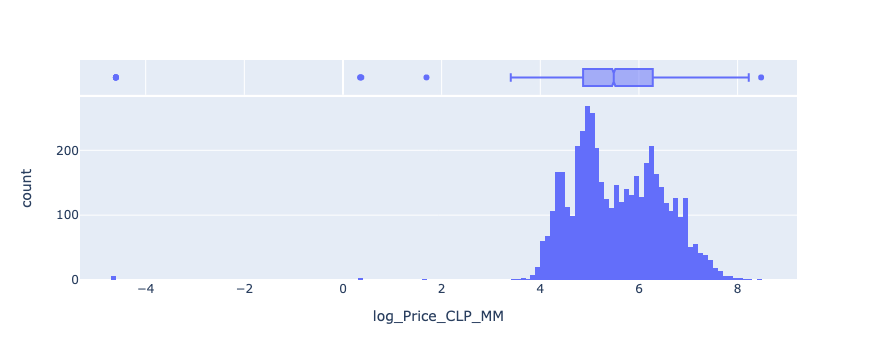

In [75]:
fig = px.histogram(data, x="log_Price_CLP_MM",marginal='box')
fig.show()

In [76]:
data.rename(columns={"Built Area": "Built_Area", "Total Area": "Total_Area"}, inplace=True)
data.columns

Index(['Dorms', 'Baths', 'Built_Area', 'Total_Area', 'Parking', 'Sector',
       'Price_CLP_MM', 'log_Price_CLP_MM'],
      dtype='object')

In [77]:
modelo1 = smf.ols(formula='log_Price_CLP_MM ~ Dorms + Baths + Built_Area + Total_Area + Parking + Sector', data=data)

resultados1 = modelo1.fit()

print(resultados1.summary())

                            OLS Regression Results                            
Dep. Variable:       log_Price_CLP_MM   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     644.8
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:37:43   Log-Likelihood:                -4448.6
No. Observations:                4743   AIC:                             8921.
Df Residuals:                    4731   BIC:                             8999.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.66

Quizás se vean algunos cambios al no considerar la variable área total. 

In [78]:
modelo2 = smf.ols(formula='log_Price_CLP_MM ~ Dorms + Baths + Built_Area + Parking + Sector', data=data)

resultados2 = modelo2.fit()

print(resultados2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_Price_CLP_MM   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     708.6
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:37:44   Log-Likelihood:                -4450.3
No. Observations:                4743   AIC:                             8923.
Df Residuals:                    4732   BIC:                             8994.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.66

No hubo cambios relevantes entre ambos modelos planteados. A primera vista se puede comentar que la estimación fue exitosa, ya que se logró estimar todos los parámetros. Además se obtiene un $R^{2}$ decente y los betas obtenidos parecen razonables, se ahondará en esto más adelante. 

Por otra parte, los errores estándar son pequeños, por lo que se puede decir que las estimaciones son precisas.

### 4.
**Analice la calidad del modelo estimado. Para esto comente acerca de las métricas utilizadas para evaluar, los supuestos detrás de los modelos o del método de estimación. Por ejemplo, si se cumple o no algun supuesto de OLS, si el estimador es insesgado, la varianza que posee, etc.**

Se obtuvo un $R^{2}$ de 0.6, valor muy similar al del $R^{2}$ ajustado obtenido que fue de 0.599, lo que significa que el 60% de la variabilidad del precio de las casas en la región Metropolitana es explicado por el modelo propuesto, mientras que el otro 40% queda explicado por el error. 

Con estos resultados, si bien el modelo no es malo, existe bastante espacio de mejora, para lograr mejorar estos resultados se consideran las siguientes opciones: 

- Combinar variables para observar si existen efectos potenciados
- Crear variables que podrían ser más significativas a partir de las que se tienen, por ejemplo obtener el área de patio a partir de la resta entre área total y área construida.
- Buscar otros set de datos que ayuden a complementar el dataset que se está utilizando. Por ejemplo número de delitos en la zona o cercanía de la casa a servicios como hospitales, centors de educación, centros de recreación, etc; también la cercanía a lugares que se consideran riesgosos como cárceles.

En cuanto a los supuestos OLS:

- Linealidad: como se explicó anteriormente, se cumple por definición del modelo.

- No multicolinealidad: dado que las regresiones no se indefinen, no existe dependencia lineal entre variables independientes. Así, los coeficientes pueden ser estimados por OLS.

- Muestras aleatorias: se cumple por lo explicado anteriormente.

- Exogeneidad: como se adelantaba este es el supuesto más complejo de cumplir y comprobar, en la parte 2 se detalla más al respecto. 

- Homocedasticidad: en el siguiente bloque de código se grafica la relación entre los residuos (error) con respecto al precio, donde se puede apreciar que la varianza disminuye con el precio, por lo que este supuesto no se cumple para todos los precios.



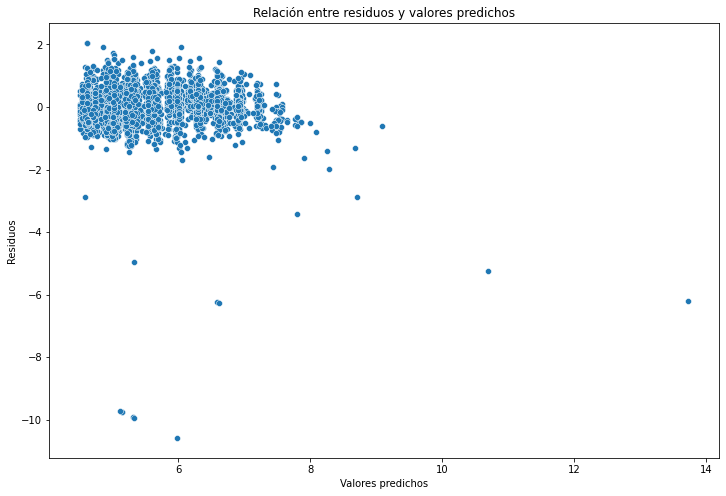

In [79]:
# obtenemos los valores predichos y residuos del modelo
predicted_values = resultados1.predict()
residual_values = resultados1.resid

# Residuos en función de los valores predichos
plt.figure(figsize=(12, 8))
chart = sns.scatterplot(x=predicted_values, y=residual_values)
chart.set_title("Relación entre residuos y valores predichos")
chart.set_xlabel("Valores predichos")
chart.set_ylabel("Residuos")
plt.show()

In [80]:
data['log_Price_CLP_MM']

0       4.653960
1       4.852967
2       4.317488
3       3.970292
4       4.317488
          ...   
4742    4.443357
4743    7.209651
4744    7.820560
4745    8.226025
4746    6.344653
Name: log_Price_CLP_MM, Length: 4747, dtype: float64

# Parte 2: Análisis e Interpretación

**Interprete las estimaciones obtenidas para sus parámetros (los más importantes en su estudio). Por ejemplo, si ajusta un modelo de regresión lineal por OLS, interprete los beta obtenidos. ¿Qué puede concluir al respecto? ¿Qué puede concluir de la pregunta de investigación que se planteó? ¿Existen potenciales sesgos que pueda identificar? ¿Existen problemas de endogeneidad? ¿Existe significancia estadística para los efectos estudiados? ¿Cómo afecta la calidad del modelo estudiada en la parte anterior en esta interpretación/resultados?**

**Interpretación de los beta obtenidos**

En cuanto a los beta del modelo 1 se tiene:

- **Intercepto: 0.46612** Esto nos dice el valor de la categoría que no estamos considerando, en este caso el sector Centro, además de ser el valor base para el resto de categorias. 

- **Sector Nororiente: 0.6501** Significa que si la casa está en el sector Nororiente, aumenta un 65,01% el precio, respecto al caso base. 

- **Sector Norponiente: -0.5040** Indica que si la casa está en el sector Norponiente, disminuye un 50,4% el precio, respecto al caso base. 

- **Sector Norte: -0.0777** Significa que si la casa está en el sector Norte, disminuye un 7,77% el precio, respecto al caso base. 

- **Sector Sur: -0.4251** Significa que si la casa está en el sector Sur, el precio disminuye en un 42,51% respecto al caso base. 

- **Sector Suroriente: -0.3075** Indica que si la casa está en el sector Suroriente, el precio disminuye en un 30,75% respecto al caso base. 

- **Sector Surponiente: -0.4124** Nos dice que si la casa está en el sector Surponiente, el precio disminuye en un 41,24% respecto al caso base. 

- **Dormitorios: 0.0299** Este valor de beta significa que si la casa tiene 1 dormitorio más, el precio aumentará en un 2.99%

- **Baños: 0.2865** Este valor de beta nos dice que si la casa tiene 1 baño más, el precio aumentará en un 28.65%

- **Área Construida: 7.798e-06** Este valor de beta habla de que si aumenta en 1 $m^{2}$ el área construida, el precio aumentará en un 7.798e-04%. Con lo cual se puede decir que esta variable no tiene un peso muy relevante en el precio final de una casa.

- **Área Total: 1.62e-06** Similar al caso anterior, este valor de beta habla de que si aumenta en 1 $m^{2}$ el área total, el precio aumentará en un 1.62e-04%. Al igual que en el caso anterior, esta variable impactará mientras más metros cuadrados sean los que aumentan.

- **Estacionamiento: 0.0011** Este valor de beta nos dice que si la casa tiene 1 estacionamiento más, el precio aumentará en un 0.11%. Lo cual tiene sentido, ya que por lo general las personas no tienen tantos autos y si requieren más estacionamientos, se preocupan de que exista el espacio para habilitarlos. 

**¿Qué puede concluir de la pregunta de investigación que se planteó?**

Se puede concluir, dado que las variables escogidas explican en un 60% el modelo, que el precio de las casas en la región metropolitana es explicado en gran medida por el sector en que se encuentra la casa, junto con la cantidad de baños y piezas que tiene. 

Por lo anterior, hay evidencia estadística de que existen sectores que presentan casas con mayor valor dentro de la región, que es el caso del sector Nororiente, donde se encuentran comunas como Providencia, Las Condes, La Reina, etc, lo cual es totalmente esperado, ya que son comunas con mejores ingresos e índices de vida en general.

**¿Existen potenciales sesgos que pueda identificar?**

Si, estos se deben a como fueron obtenidos los datos, es decir: sesgo de selección, ya que 
- Sólo se consideraron casas y no departamentos, se sabe que no en todas las comunas hay igual cantidad de casas.
- Sólo se consideraron las publicaciones de https://chilepropiedades.cl/, pero se sabe que esta no es la única página para cotizar viviendas.

Además, existe sesgo de variable omitida. Como se adelantaba anteriormente, hay variables que no se presentan en el dataset y que son relevantes en el valor de una casa, como por ejemplo la cercanía a la locomoción, centros de salud, educación, recreación, etc. 

**¿Existen problemas de endogeneidad?**

La endogeneidad se relaciona fuertemente al sesgo de variable omitida. Es posible que las variables explicativas se correlacionen a algún factor que no estamos observando, por ejemplo
- Las variables que contienen las características de una casa (dormitorios, baños, estacionamiento, etc) se relacionan a la constructora que haya estado a cargo.
- Las variables explicativas con las que contamos se relacionan al propósito que se le dará a la vivienda, por ejemplo una casona grande en el centro, probablemente sea utilizada para arrendar por piezas.


**¿Existe significancia estadística para los efectos estudiados?**

Dados los p-valores obtenidos para cada uno de los betas en el modelo, se concluye que existe significancia estadistica al 5% para todos los betas y existe significancia estadística al 1% para todos los betas a excepción de ```Sector[T_Norte]``` y ```Built_Area```. 

**¿Cómo afecta la calidad del modelo estudiada en la parte anterior en esta interpretación/resultados?**

La interpretación del modelo, es válida considerando que este explica en un 60% la variabilidad de los datos. Pero existe un gran espacio de mejora que permitiría afinar los resultados y por ende precisar las interpretaciones. Por ejemplo, cruzar el dataframe con otras fuentes de información para tener menos sesgo de variable omitida; o obtener datos similares, pero de otras páginas web para evitar el sesgo de selección.

### ------------------------------------ Anexo

A continuación se intenta mejorar los resultados obtenidos, añadiendo nuevas columnas al dataframe, estas provienen de https://datoscomunales.pazciudadana.cl/ y se relacionan con la seguridad del sector en el que se encuentra cada casa. 

In [81]:
#Se cargan los datos limpios (Tarea 1)
data_aux = pd.read_csv("data_merged.csv")
data_aux.head()

,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,Realtor,Price_CLP_MM,F_homicidio,...,F_r_veh,T_r_veh,R_r_veh,F_r_violencia,T_r_violencia,R_r_violencia,F_violacion,T_violacion,R_violacion,Sector
0,PedroAguirreCerda,Rucalhue,2,1.0,112.0,145.0,1.0,Legales y Propiedades SpA,105.00,9,...,232,217.8,alto,701,658.2,alto,28,26.3,alto,Sur
1,EstaciónCentral,AvenidaLasParcelas,3,1.0,59.0,243.0,2.0,Propiedadesrs,128.12,19,...,648,297.7,alto,2059,946.0,crítico,48,22.1,alto,Surponiente
2,Colina,PasajeGonzaloRojas,3,1.0,103.0,73.0,1.0,Patricio Gajardo propiedades,75.00,16,...,245,129.1,medio,697,367.3,medio,48,25.3,alto,Norte
3,Colina,HernánDíazArrieta2820,2,1.0,57.0,67.0,1.0,Patricio Gajardo propiedades,53.00,16,...,245,129.1,medio,697,367.3,medio,48,25.3,alto,Norte
4,Colina,GabrielaMistral/PabloNeruda,3,1.0,70.0,80.0,2.0,Patricio Gajardo propiedades,75.00,16,...,245,129.1,medio,697,367.3,medio,48,25.3,alto,Norte


In [82]:
data_aux["log_Price_CLP_MM"] = data_aux["Price_CLP_MM"].apply(lambda x: np.log(x))

data_aux.replace([np.inf, -np.inf], np.nan, inplace=True)

data_aux.dropna(how='all', inplace=True)

data_aux.head()

,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,Realtor,Price_CLP_MM,F_homicidio,...,T_r_veh,R_r_veh,F_r_violencia,T_r_violencia,R_r_violencia,F_violacion,T_violacion,R_violacion,Sector,log_Price_CLP_MM
0,PedroAguirreCerda,Rucalhue,2,1.0,112.0,145.0,1.0,Legales y Propiedades SpA,105.00,9,...,217.8,alto,701,658.2,alto,28,26.3,alto,Sur,4.653960
1,EstaciónCentral,AvenidaLasParcelas,3,1.0,59.0,243.0,2.0,Propiedadesrs,128.12,19,...,297.7,alto,2059,946.0,crítico,48,22.1,alto,Surponiente,4.852967
2,Colina,PasajeGonzaloRojas,3,1.0,103.0,73.0,1.0,Patricio Gajardo propiedades,75.00,16,...,129.1,medio,697,367.3,medio,48,25.3,alto,Norte,4.317488
3,Colina,HernánDíazArrieta2820,2,1.0,57.0,67.0,1.0,Patricio Gajardo propiedades,53.00,16,...,129.1,medio,697,367.3,medio,48,25.3,alto,Norte,3.970292
4,Colina,GabrielaMistral/PabloNeruda,3,1.0,70.0,80.0,2.0,Patricio Gajardo propiedades,75.00,16,...,129.1,medio,697,367.3,medio,48,25.3,alto,Norte,4.317488


In [83]:
data_aux.rename(columns={"Built Area": "Built_Area", "Total Area": "Total_Area"}, inplace=True)
data_aux.columns

Index(['Comuna', 'Ubicacion', 'Dorms', 'Baths', 'Built_Area', 'Total_Area',
       'Parking', 'Realtor', 'Price_CLP_MM', 'F_homicidio', 'T_homicidio',
       'R_homicidio', 'F_rlh', 'T_rlh', 'R_rlh', 'F_rlnh', 'T_rlnh', 'R_rlnh',
       'F_r_veh', 'T_r_veh', 'R_r_veh', 'F_r_violencia', 'T_r_violencia',
       'R_r_violencia', 'F_violacion', 'T_violacion', 'R_violacion', 'Sector',
       'log_Price_CLP_MM'],
      dtype='object')

In [84]:
modelo3 = smf.ols(formula='log_Price_CLP_MM ~ Dorms + Baths + Built_Area + Total_Area + Parking + Comuna + R_homicidio + R_rlh + R_rlnh + R_r_veh + R_r_violencia', data=data_aux)

resultados3 = modelo3.fit()

print(resultados3.summary())

                            OLS Regression Results                            
Dep. Variable:       log_Price_CLP_MM   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     174.0
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:37:52   Log-Likelihood:                -4041.8
No. Observations:                4743   AIC:                             8192.
Df Residuals:                    4689   BIC:                             8541.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

En general al agregar más detalles y utilizar comuna en vez de sector, se logra un mejor $R^{2}$, es decir, el modelo logra explicar más de la variabilidad de los precios, en este caso un 66,3%. Por otra parte, tanto el AIC como el BIC disminuyen, lo que también indica un mejor modelo. 

### -----------------------------Anexo 2

Diccionario utilizado para obtener los sectores

In [85]:
dic_sector = {'QuintaNormal' : 'Norponiente',
              'PedroAguirreCerda' : 'Sur',
              'EstaciónCentral' : 'Surponiente',
              'Colina' : 'Norte',
              'LaFlorida' : 'Suroriente',
              'Maipú' : 'Surponiente',
              'SanBernardo' : 'Sur',
              'Santiago' : 'Centro',
              'LasCondes' : 'Nororiente',
              'Lampa' : 'Norte',
              'LaPintana' : 'Sur',
              'PuenteAlto' : 'Suroriente',
              'Huechuraba' : 'Norte',
              'SanMiguel' : 'Sur',
              'Ñuñoa' : 'Nororiente',
              'LaGranja' : 'Sur',
              'Pudahuel' : 'Norponiente',
              'Buin' : 'Sur',
              'Peñalolén' : 'Suroriente',
              'Talagante' : 'Surponiente',
              'Quilicura' : 'Norte',
              'PadreHurtado' : 'Surponiente',
              'Tiltil' : 'Norponiente',
              'LoBarnechea' : 'Nororiente',
              'Providencia' : 'Nororiente',
              'LaReina' : 'Nororiente',
              'Conchalí' : 'Norte',
              'Peñaflor' : 'Surponiente',
              'ElMonte' : 'Surponiente',
              'Macul' : 'Suroriente',
              'CaleradeTango' : 'Suroriente',
              'Independencia' : 'Norte',
              'Paine' : 'Sur',
              'LaCisterna' : 'Sur',
              'Melipilla' : 'Surponiente',
              'Recoleta' : 'Norte', 
              'LoPrado' : 'Norponiente', 
              'Vitacura' : 'Nororiente', 
              'LoEspejo' : 'Sur',
              'ElBosque' : 'Sur', 
              'Cerrillos' : 'Surponiente', 
              'Renca' : 'Norponiente', 
              'SanJoaquín' : 'Sur', 
              'IsladeMaipo' : 'Surponiente',
              'Pirque' : 'Suroriente', 
              'SanRamón' : 'Sur', 
              'CerroNavia' : 'Norponiente', 
              'Curacaví' : 'Surponiente', 
              'SanJosédeMaipo' : 'Suroriente'}